<a href="https://colab.research.google.com/github/d9249/Code_Crack/blob/main/Image_length.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


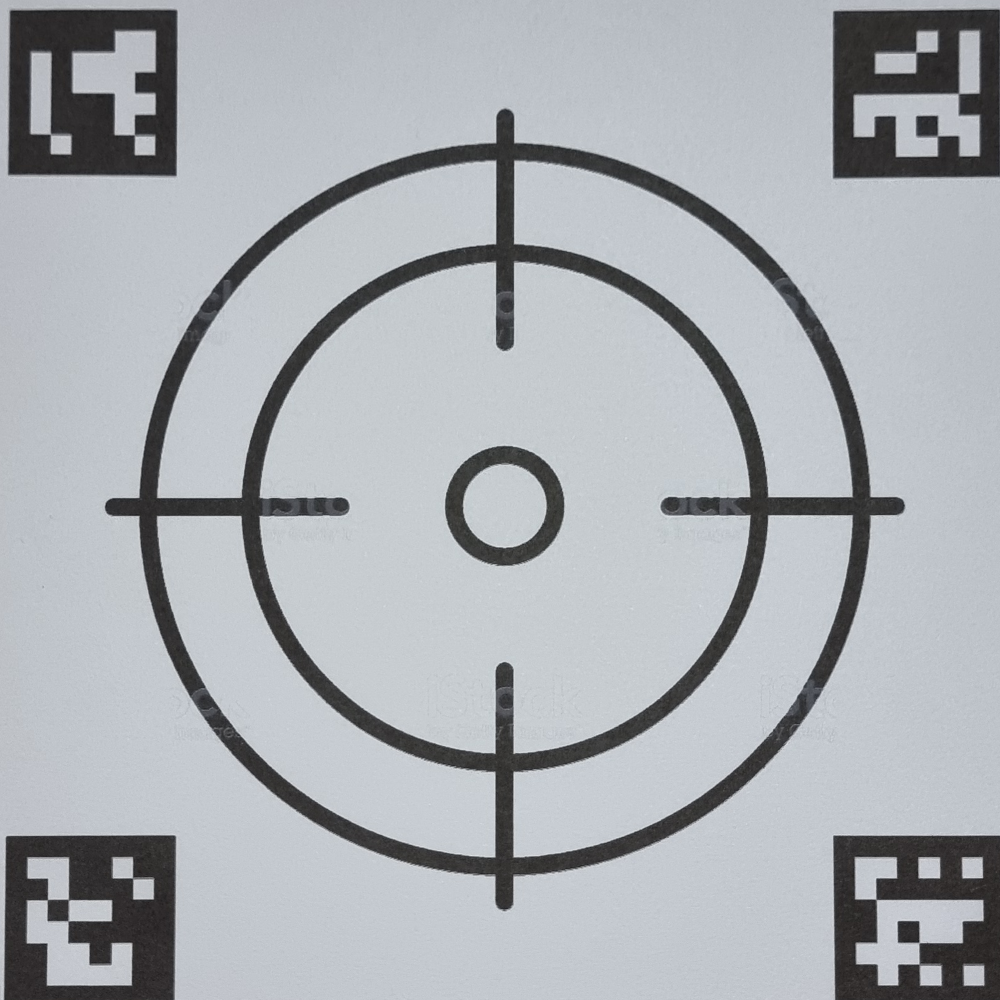

True

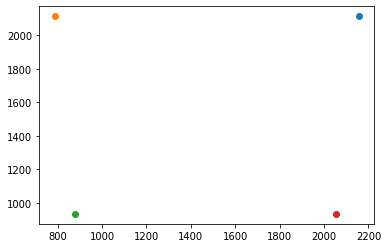

In [17]:
import numpy as np
import cv2, PIL
from cv2 import aruco
from matplotlib import pyplot as plt
import matplotlib as mpl
import pandas as pd
from PIL import Image
from google.colab.patches import cv2_imshow

img = cv2.imread("/content/drive/MyDrive/marker_image/bottom.jpg")

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
parameters =  aruco.DetectorParameters_create()
corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)
frame_markers = aruco.drawDetectedMarkers(img.copy(), corners, ids)

#cv2_imshow(frame_markers)

for i in range(len(ids)):
    c = corners[i][0]
    plt.plot([c[:, 0].mean()], [c[:, 1].mean()], "o", label = "id={0}".format(ids[i]))
    if ids[i][0] == 1:
      ap = corners[i][0][0]
    if ids[i][0] == 2:
      cp = corners[i][0][1]
    if ids[i][0] == 3:
      bp = corners[i][0][3]
    if ids[i][0] == 4:
      dp = corners[i][0][2]

# 좌표점은 좌상->좌하->우상->우하
pts1 = np.float32([ap, bp, cp, dp])

# 좌표의 이동점
pts2 = np.float32([[10,10],[10,1000],[1000,10],[1000,1000]])

M = cv2.getPerspectiveTransform(pts1, pts2)
dst = cv2.warpPerspective(img, M, (1000,1000))
cv2_imshow(dst)
cv2.imwrite('/content/drive/MyDrive/marker_image/image.jpg', dst)

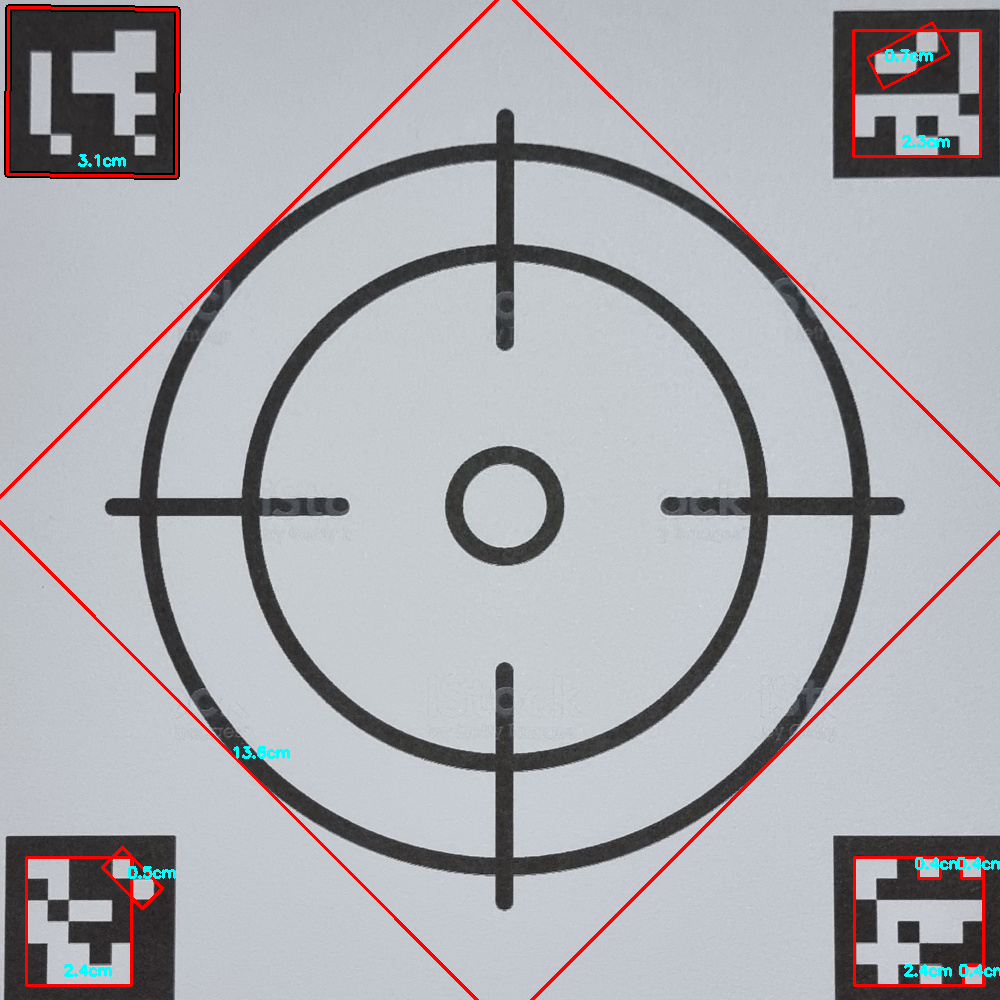

-1

In [24]:
import cv2
import numpy as np
import imutils
from scipy.spatial.distance import euclidean
from imutils import perspective
from imutils import contours

img = cv2.imread('/content/drive/MyDrive/marker_image/image.jpg')
marker = 3.1

def imgscal(img, scale_percent):
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    return img

img = imgscal(img, 30)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (7, 7), 0)

edged = cv2.Canny(gray, 50, 100)
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)
# find contours in the edge map
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
(cnts, _) = contours.sort_contours(cnts)
cnts = [x for x in cnts if cv2.contourArea(x) > 100]

def midpoint(ptA, ptB):
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

bluerect = cv2.minAreaRect(cnts[0])
bluebox = cv2.boxPoints(bluerect)
bluebox = np.array(bluebox)
bluebox = perspective.order_points(bluebox.astype(int))
(tl, tr, br, bl) = bluebox
tm = midpoint(tl, tr)
tb = midpoint(bl, br)
dist_in_pixel = euclidean(tm,tb)
dist_in_cm = marker
pixel_per_cm = dist_in_pixel / dist_in_cm
cv2.drawContours(img, [bluebox.astype(int)], 0, (0, 0, 0), 5)

for cnt in cnts:
    if cv2.contourArea(cnt) < 100:
        continue
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.array(box)
    box = perspective.order_points(box.astype(int))
    (tl, tr, br, bl) = box
    tm = midpoint(tl, tr)
    tb = midpoint(bl, br)
    wid = euclidean(tm, tb)/pixel_per_cm
    cv2.drawContours(img, [box.astype("int")], -1, (0, 0, 255), 2)
    cv2.putText(img, "{:.1f}cm".format(wid), (int(tm[0] - 15), int(tb[1] - 10)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)

cv2_imshow(img)
cv2.waitKey(0)

7.908262614329216
8.8


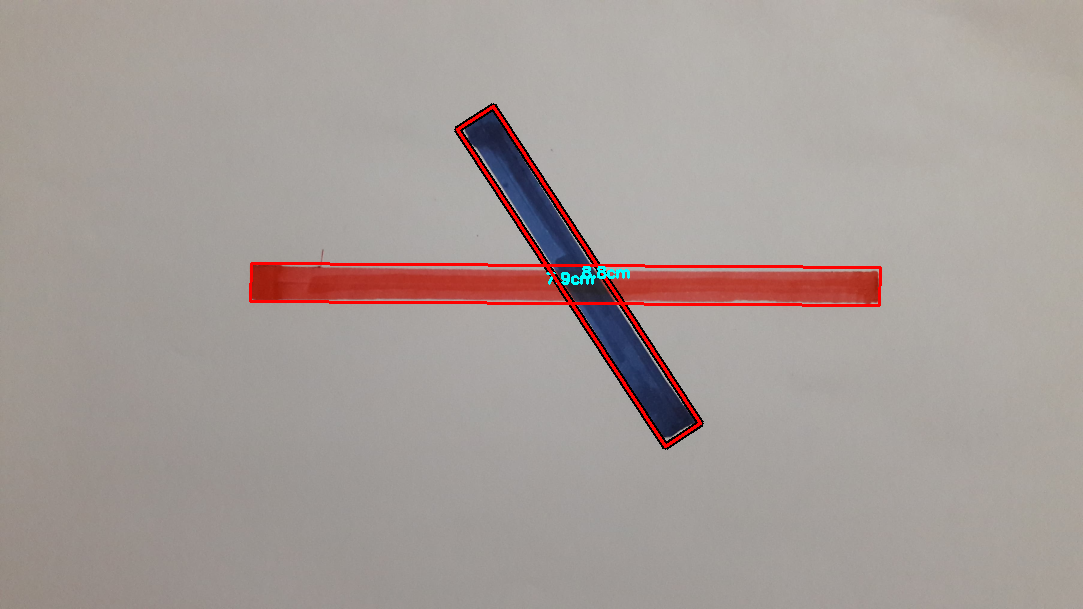

-1

In [31]:
import cv2
import numpy as np
import imutils
from scipy.spatial.distance import euclidean
from imutils import perspective
from google.colab.patches import cv2_imshow

# img = cv2.imread('len_8.6.jpg')
img = cv2.imread('/content/drive/MyDrive/marker_image/len_8.8.jpg')
# img = cv2.imread('len_9.jpg')
# img = cv2.imread('len_7.2.jpg')
# img = cv2.imread('/content/drive/MyDrive/marker_image/image.jpg')
# marker = 3.1
blue_length_cm = 8.8

def imgscal(img, scale_percent):
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
    return img


img = imgscal(img, 30)

imgHsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
lower_red = np.array([(0, 150, 50)])
upper_red = np.array([10, 255, 255])
lower_blue = np.array([90, 50, 50])
upper_blue = np.array([150, 255, 255])

imggray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
redMask = cv2.inRange(imgHsv, lower_red, upper_red)
blueMask = cv2.inRange(imgHsv, lower_blue, upper_blue)
# -----------------------------------------------------------
def midpoint(ptA, ptB):
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)


# -----------------------------------------------------------
# ----------------------------------------------------------------------------------------------
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(100,100))
blueCanny = cv2.Canny(blueMask, 1, 1)
redCanny = cv2.Canny(redMask, 1, 1)
blueCanny = cv2.dilate(blueCanny, kernel, iterations=1)
blueCanny = cv2.erode(blueCanny, kernel, iterations=1)
redCanny = cv2.dilate(redCanny, kernel, iterations=1)
redCanny = cv2.erode(redCanny, kernel, iterations=1)

blueCanny = cv2.morphologyEx(blueCanny, cv2.MORPH_CLOSE, kernel)
redCanny = cv2.morphologyEx(redCanny, cv2.MORPH_CLOSE, kernel)

blueCanny = cv2.Canny(blueCanny, 1, 1)
redCanny = cv2.Canny(redCanny, 1, 1)
#
# # ----------------------------------------------------------------------------------------------
blueContours, blueher = cv2.findContours(blueCanny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
redContours, redher = cv2.findContours(redCanny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

blueContours = [x for x in blueContours if cv2.contourArea(x) > 100]
redContours = [x for x in redContours if cv2.contourArea(x) > 100]

# areas = [cv2.contourArea(c) for c in blueContours]
# max_index  = np.argmax(areas)
# blueContours = blueContours[max_index]
#
# areas = [cv2.contourArea(c) for c in redContours]
# max_index  = np.argmax(areas)
# redContours = redContours[max_index]

blue_rect = cv2.minAreaRect(blueContours[0])
blue_box = cv2.boxPoints(blue_rect)
blue_box = np.array(blue_box)
blue_box = perspective.order_points(blue_box.astype(int))
(tl, tr, br, bl) = blue_box
tm = midpoint(tl, tr)
tb = midpoint(bl, br)
dist_in_pixel = euclidean(tm,tb)
dist_in_cm = blue_length_cm
pixel_per_cm = dist_in_cm/dist_in_pixel
# pixel_per_cm = dist_in_pixel / dist_in_cm
cv2.drawContours(img, [blue_box.astype(int)], 0, (0, 0, 0), 5)

for cnt in redContours:
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.array(box)
    box = perspective.order_points(box.astype(int))
    (tl, tr, br, bl) = box
    tm = midpoint(tl, tr)
    tb = midpoint(bl, br)
    wid = euclidean(tm, tb)*pixel_per_cm
    print(wid)
    cv2.drawContours(img, [box.astype("int")], -1, (0, 0, 255), 2)
    cv2.putText(img, "{:.1f}cm".format(wid), (int(tm[0] - 20), int(tb[1] - 20)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)

for cnt in blueContours:
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.array(box)
    box = perspective.order_points(box.astype(int))
    (tl, tr, br, bl) = box
    tm = midpoint(tl, tr)
    tb = midpoint(bl, br)
    wid = euclidean(tm, tb) * pixel_per_cm
    print(wid)
    cv2.drawContours(img, [box.astype("int")], -1, (0, 0, 255), 2)
    cv2.putText(img, "{:.1f}cm".format(wid), (int(tm[0] - 15), int(tb[1] - 10)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)

# cv2_imshow(redCanny)
# cv2_imshow(blueCanny)
cv2_imshow(img)
# cv2.imshow('gray', gray)
cv2.waitKey(0)